Label Pair Graph Kernels are proposed [On Graph Kernels:
Hardness Results and Efficient Alternatives](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.152.8681&rep=rep1&type=pdf)


*   **Kernels based on label pairs**

      *  Derivation of Kernel
      *  Implementation and Illustartion of the Kernel 
      *  Doing Graph Classificaiton on MUTANG dataset using Label Pair Kernel

*   **Kernels based on contiguous label sequences**
      *  contiguous label sequences and direct products 
      *  Implementation and Illustration of the Kernel
      *  Doing Graph Classification on MUTANG dataset using contiguous label sequences

*    **Comparision of both kernels**
*     **Doing Graph Classification on Large Datasets**
*     **Seeing if Multiple Cores and Sparsity helps in Speeding up**





#**Kernels based on Label Pairs**

let $w \in \mathcal{W}_{n}(G)$ denote the set of all possible walks with $n$ edges in $G$ and $\lambda$ be a sequence $\lambda_{0},\lambda_{1} , \dots $ of weights $\lambda_{n} \geq 0 $ for all $n \in \mathbb{N}$. for a given walk $w \in \mathcal{W}_{n}(G)$. let $l_{1}(w)$ denote the label of the first vertex and $l_{n+1}(w)$ denote the label of the last vertex of the walk.

The label pair feature space is defined by one feature $\phi_{\ell_{i} , \ell_{j}}$ for each pair of the labels $\ell_{i}̣,\ell_{j}$

$$ \begin{align*}  \phi_{\ell_{i},\ell_{j}}(G) &= \sum_{n=0}^{\infty} \lambda_n . \text{number of walks of length $n$ that start with vertex which has label i and end with vertex which has label j} \\
&= \sum_{i=0}^{\infty}  \lambda_{n} . |\{ w \in \mathcal{W}_{n}(G) : l_{1}(w) = \ell_i \land l_{n+1}(w) = \ell_{j} \}| 
\end{align*} $$

Now, 


$$ \begin{align*} K(G,G')&= \left < \phi(G) , \phi(G') \right > \\
&= \sum_{\ell_{i} , \ell_{j}} \left[ \sum_{n=0}^{\infty} \lambda_{n}  |\{ w \in \mathcal{W}_{n}(G) : l_{1}(w) = \ell_i \land l_{n+1}(w) = \ell_{j} \}| \,.\ \sum_{m=0}^{\infty} \lambda'_ {m}|\{ w \in \mathcal{W}_{m}(G') : l_{1}(w) = \ell_i \land l_{n+1}(w) = \ell_{j} \}| \right]  \\
&= \sum_{n=0}^{\infty} \sum_{m=0}^{\infty}  \left[ \sum_{\ell_i, \ell_j} \lambda_{n} \lambda_{m}' |\{ w \in \mathcal{W}_{n}(G) : l_{1}(w) = \ell_i \land l_{n+1}(w) = \ell_{j} \}|. |\{ w \in \mathcal{W}_{m}(G') : l_{1}(w) = \ell_i \land l_{n+1}(w) = \ell_{j} \}|  \right] \\
&= \sum_{n=0}^{\infty} \sum_{m=0}^{\infty} \sum_{\ell_i,\ell_j} \lambda_{n} (LE^nL^{T})_{ij}. \lambda_{m} (L'E'^{n}L'^{T})_{ij} \\
&=  \sum_{n=0}^{\infty} \sum_{m=0}^{\infty} \left<L (\lambda_{n}E^n)L^{T},L'(\lambda_{m}E'^{m})L'^{T}\right> \\
&= \left< \sum_{n=0}^{\infty}  L (\lambda_{n}E^n)L^{T}, \sum_{m=0}^{\infty} L'(\lambda_{m}E'^{m})L'^{T}\right> \\
&= \left<  L \left(\sum_{n=0}^{\infty}  \lambda_{n}E^n \right)L^{T},  L'\left(\sum_{n=0}^{\infty} \lambda_{n}E'^{n}\right)L'^{T} \right> \\
\end{align*}$$



In [ ]:
#install python-igraph : we use IGraph for manipulating and storing graph data
#install cairocffi : needed for ploting for python-igraph

!pip install python-igraph
!pip install cairocffi

In [ ]:
import os
import platform
import numpy as np
import igraph as ig
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from IPython.core.display import display, Image
from tqdm import tqdm
from numpy import linalg as LA
from itertools import combinations_with_replacement
import multiprocessing as mp
from sklearn.svm import SVC
import random

In [ ]:
print("Python Version: ", platform.python_version())
print("Number of processors: ", mp.cpu_count())

Python Version:  3.7.10
Number of processors:  2


In [ ]:
#mounting the data  on drive 

from google.colab import drive
drive.mount('/content/drive')
path = 'data/graph_data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#retreving the file names

def get_data(path):
  graph_files = []
  for file in os.listdir(path):
    if file.endswith('gml'):
        graph_files.append(os.path.join(path,file))
  graph_files.sort()
  return graph_files
  

In [ ]:
# making sure that multiple igraph plots are shown in single jupyter cell

def plot(G,id):
  print("Graph "+id,end= "\n\n")
  ig.plot(G,bbox = (200, 200)).save('temporary.png') 
  display(Image(filename='temporary.png'))
  os.remove('temporary.png')

Graph G1



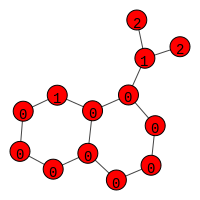

Graph G2



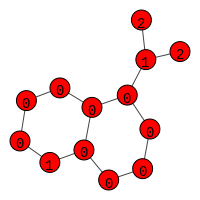

In [ ]:
#sample graph visualization

path = '/content/drive/MyDrive/data/graph_data/MUTAG'
graph_files = get_data(path)
G0 = ig.read(graph_files[1])
G1 = ig.read(graph_files[2])
plot(G0,"G1")
plot(G1,"G2")

Label Matrix $\text{L}$ is of size $|\mathcal{L}| \times |\mathcal{V}|$ where $|\mathcal{L}|$ is number of unique labels. 

In [ ]:
#read all .gml files as Igraph objects

def get_Gs(path):
  graph_files = get_data(path)
  Gs = []
  for graph_file in tqdm(graph_files):
    g = ig.read(graph_file)
    Gs.append(g)
  return Gs  



In [ ]:
#scan through all graphs and find total number of unique labels

def get_sizeof_L(graphs):
  """
  Parameters 
  graphs : list of Igraph objects
  Returns 
  sizeof_L : int 
  """

  n_Gs = len(graphs)
  G_node_labels = list()
  for g in graphs:
    g_node_labels = g.vs['label']
    G_node_labels.extend(g_node_labels)
  sizeof_L = len(set(G_node_labels))
  return sizeof_L  



In [ ]:
mutang_path = '/content/drive/MyDrive/data/graph_data/MUTAG'
Gs = get_Gs(mutang_path)
sizeof_L = get_sizeof_L(Gs)
print(" Number of unique labels : ",sizeof_L)

100%|██████████| 188/188 [00:00<00:00, 576.18it/s]

 Number of unique labels :  7


In [ ]:
# builds the label matrix for Igraph g

def get_labelmat(g,sizeof_L):
  L_g = np.zeros((sizeof_L,g.vcount()))
  g_labels = g.vs['label']
  for i,l_r in enumerate(g_labels):
    r = int(l_r)
    if L_g[r][i] == 0. :
      L_g[r][i] = 1
  return L_g  
  

In [ ]:
print("Label Matrix L for Graph G0: ")
L_G0  = get_labelmat(G0,sizeof_L)
print(L_G0,end= "\n\n")
print("Label Matrix L for Graph G1: ")
L_G1  = get_labelmat(G1,sizeof_L)
print(L_G1,end= "\n\n")
print("Label Matrix L for Graph G0: ")
E_G0  = np.asarray(G0.get_adjacency().data)
print(E_G0,end= "\n\n")
print("Label Matrix L for Graph G1: ")
E_G1  = np.asarray(G1.get_adjacency().data)
print(E_G1,end= "\n\n")

Label Matrix L for Graph G0: 
[[0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Label Matrix L for Graph G1: 
[[0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Label Matrix L for Graph G0: 
[[0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 1 0]

###**Sufficient Condition for convergence of summation of matrix powers**

Note that If $E$ is adjacency matrix, then $\displaystyle \sum_{i=0}^{\infty} \gamma^i E^i$ converges iff $\gamma < \frac{1}{\text{max_degree}(G)}$ 

hence we can set  weight sequence $\lambda_n = \left[\frac{1}{\text{max_degree}(G)} - \epsilon  \right]^{n}$ for small $\epsilon$ and $\displaystyle \sum_{n=0}^{\infty} \lambda_n E^n$ would converge to $\left(I - \gamma. E\right)^{-1}$

In [ ]:
#find the Delta(G) (which is maximum degree)

def get_matpow(g,eps=0.001):
  max_deg = g.maxdegree()
  gamma = 1/max_deg - eps
  I = np.eye(g.vcount()) 
  E = np.asarray(g.get_adjacency().data)
  matpow = LA.inv(I - gamma*E)
  return matpow

In [ ]:
#calculating feature representation of Graph

def get_features(g):
  L  = get_labelmat(g,sizeof_L)
  mat_pow_sum = get_matpow(g)
  feature_matrix = L @ mat_pow_sum @ L.T 
  features = feature_matrix.ravel()
  return features

  

In [ ]:
# computes the features for pair of graphs and computes inner product

def K(g1,g2):
  features_g0 = get_features(g1)
  features_g1 = get_features(g2)
  K = np.dot(features_g0, features_g1)
  return K 

In [ ]:
# builds kernel matrix for list of graphs

def kernel_mat(graphs):
  N_gs = len(graphs)
  Kernel = np.zeros((N_gs,N_gs))
  for i,j in tqdm(combinations_with_replacement(range(N_gs),2)):
    Kernel[i][j] = Kernel[j][i] = K(graphs[i],graphs[j])
  return Kernel  



In [ ]:
# Does Graph Classification and returns Accuracy

def graph_classification(Kernel_train,Kernel_test,y_train,y_test):
  clf = SVC(kernel='precomputed')
  clf.fit(Kernel_train,y_train)
  y_pred = clf.predict(Kernel_test)
  acc  = accuracy_score(y_test,y_pred)
  return acc

In [ ]:
# Does StratifiedKFold split and returns Avg Accuracy score

def use_k_fold(Kernel,labels,n_splits):

  skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
  acc_scores = list()
  for train_idx,test_idx in skf.split(Kernel,labels):
    
    Kernel_train = Kernel[train_idx][:, train_idx]
    Kernel_test  = Kernel[test_idx][:,train_idx]
    y_train = labels[train_idx]
    y_test  = labels[test_idx]
    fold_score = graph_classification(Kernel_train,Kernel_test,y_train,y_test)
    acc_scores.append(fold_score)

  avg_acc_score = np.mean(acc_scores)
  return avg_acc_score  


In [ ]:
label_file = os.path.join(mutang_path, 'Labels.txt')
labels = np.loadtxt(label_file)

In [ ]:
print(len(Gs))
Kernel = kernel_mat(Gs)

151it [00:00, 1509.26it/s]

188


17766it [00:11, 1483.32it/s]


In [ ]:
n_splits = 5
avg_acc_score = use_k_fold(Kernel,labels,n_splits)
print("classification accuracy :" , avg_acc_score)

classification accuracy : 0.8621621621621621


#**Contiguous Label Sequence Kernel**


let $\mathcal{S}_n$ denote the set of all possible label sequences of walks with $n$ edges and $\lambda$ be sequence of weights. let $\mathcal{W}_n(G)$ denote the set of all possible walks with $n$ edges in graph $G$. for a given walk $w \in \mathcal{W}_{n}(G)$  let $l_{i}(w)$ denote the i-th label of the walk. 

The sequence feature space is defined by one features for each possible label sequence. In particular, for any given length $n$ and label sequence $s_1,s_2,\dots,s_{2n+1}$, the corresponding featuer value for every graph $\mathcal{G}$ is 

$$\begin{align} \phi_{s}(G) &= \sqrt{\lambda_{s}(G)} |\{ w \in \mathcal{W}_{n}(G), \forall i : s_{i} = \ell_{i}(w)\}|
\end{align}$$


we denote the direct product of graphs $G_1$ and $G_2$ is denoted as $G_1 \times G_2$. vertex set and edge set of $G_1 \times G_2$ is defined as follows 

$$
\begin{align} \mathcal{V}(G_1 \times G_2)&= \{ (v_1,v_2)  \in \mathcal{V}_1 \times \mathcal{V}_2 : \text{label}(v_1) = \text{label}(v_2) \} \\
\mathcal{E}(G_1 \times G_2) &= \{ ((u_1,u_2),(v_1,v_2)) \in \mathcal{V}^2(G_1 \times G_2) : (u_1,v_1) \in \mathcal{E}(G_1) , (u_2,v_2) \in \mathcal{E}(G_2) , \text{label}((u_1,v_1)) = \text{label}((u_2,v_2)) \}
\end{align}$$

A vertex (edge) in graph $G_1 \times G_2$ has the same label as the corresponding vertices(edges) in $G_1$ and $G_2$


$$
\begin{align} |\{ w\in \mathcal{W}_{n}(G' \times G) , \forall i : s_i = l_i(w) \}|&= |\{  w \in \mathcal{W}_{n}(G),\forall i : s_i = l_i(w) \}|.|\{  w \in \mathcal{W}_{n}(G'),\forall i : s_i = l_i(w) \}|
\end{align}$$


let $G_1,G_2$ be two graphs $\text{E}_{\times}$ denotes the adjacency matrix of their direct product $G_1 \times G_2$ $\text{E}_{\times} =  E(G_1 \times G_2)$ and let $\mathcal{V}_{\times}$ denote the vertex set of the direct product $\mathcal{V}_{\times} = \mathcal{V}(G_1 \times G_2)$. With the sequence of weights $\lambda_0,\lambda_1, \dots $ the direct product kernel is defined as 

$$\begin{align} k_{\times}(G_1,G_2) &= \sum_{i,j}^{|\mathcal{V}_{\times}|} \left[ \sum_{n=0}^{\infty} \lambda_{n}  \text{E}_{\times}^n \right]_{ij} 
\end{align}$$ if the limit exists 

then 
$$\begin{align} k_{\times}(G,G') &= \left< \phi(G) , \phi(G') \right> \end{align}$$


